# Loading Libraries

In [1]:
%%time
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

from tqdm.notebook import tqdm
import gc

import warnings
warnings.filterwarnings('ignore')

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from lightgbm import LGBMClassifier, early_stopping, log_evaluation

import xgboost as xgb
from xgboost import XGBClassifier

from catboost import CatBoostClassifier, Pool

CPU times: user 6 s, sys: 2.77 s, total: 8.77 s
Wall time: 13.1 s


# Reading Data Files

In [2]:
%%time
train = pd.read_csv('../input/playground-series-s5e6/train.csv', index_col=0)
test = pd.read_csv('../input/playground-series-s5e6/test.csv', index_col=0)

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (750000, 9)
The dimension of the test dataset is: (250000, 8)
CPU times: user 610 ms, sys: 220 ms, total: 830 ms
Wall time: 1.3 s


In [3]:
train.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
id,,,,,,,,,
0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,27,69,65,Sandy,Millets,30,6,18,28-28
2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,35,58,43,Red,Paddy,37,2,16,DAP


In [4]:
test.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
id,,,,,,,,
750000,31,70,52,Sandy,Wheat,34,11,24
750001,27,62,45,Red,Sugarcane,30,14,15
750002,28,72,28,Clayey,Ground Nuts,14,15,4
750003,37,53,57,Black,Ground Nuts,18,17,36
750004,31,55,32,Red,Pulses,13,19,14


# Data Exploration

First, we start by exploring the target variable.

In [5]:
%%time
train['Fertilizer Name'].value_counts(normalize=True)

CPU times: user 45.8 ms, sys: 233 µs, total: 46.1 ms
Wall time: 46.6 ms


Fertilizer Name
14-35-14    0.152581
10-26-26    0.151849
17-17-17    0.149937
28-28       0.148211
20-20       0.147852
DAP         0.126480
Urea        0.123089
Name: proportion, dtype: float64

From the above table, the data seems to be balanced. Next, we run a couple of sanity checks. First, we check for duplicated observations in the `train` and `test` datasets.

In [6]:
%%time
print('There are', sum(train.drop(columns=['Fertilizer Name']).duplicated()), 'duplicated observations in the train dataset')
print('There are', sum(test.duplicated()), 'duplicated observations in the test dataset')

There are 0 duplicated observations in the train dataset
There are 0 duplicated observations in the test dataset
CPU times: user 257 ms, sys: 24.6 ms, total: 281 ms
Wall time: 285 ms


We next proceed to check to potential duplicated observations that may appear in the `train` and `test` datasets.

In [7]:
%%time
to_consider = train.drop(columns=["Fertilizer Name"], axis=1).columns.tolist()

train_dup = train.drop(columns=["Fertilizer Name"], axis=1).drop_duplicates()
test_dup = test.drop_duplicates()
duplicates = pd.merge(train_dup, test_dup, on=to_consider)

print('There are', duplicates.shape[0], 'rows that appear in the train and test dataset.\n')

There are 0 rows that appear in the train and test dataset.

CPU times: user 546 ms, sys: 96 ms, total: 642 ms
Wall time: 648 ms


Next, we check for missing values in the `train` and `test` datasets.

In [8]:
%%time
print("Missing values in the train dataset \n")
print(f"{train.isna().sum()}\n")

print("Missing values in the test dataset \n")
print(test.isna().sum())

Missing values in the train dataset 

Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64

Missing values in the test dataset 

Temparature    0
Humidity       0
Moisture       0
Soil Type      0
Crop Type      0
Nitrogen       0
Potassium      0
Phosphorous    0
dtype: int64
CPU times: user 123 ms, sys: 0 ns, total: 123 ms
Wall time: 122 ms


From the above, we see there are no missing values neither in the `train` or `test` datasets. Next. we create a few charts to explore potential patterns in the data.

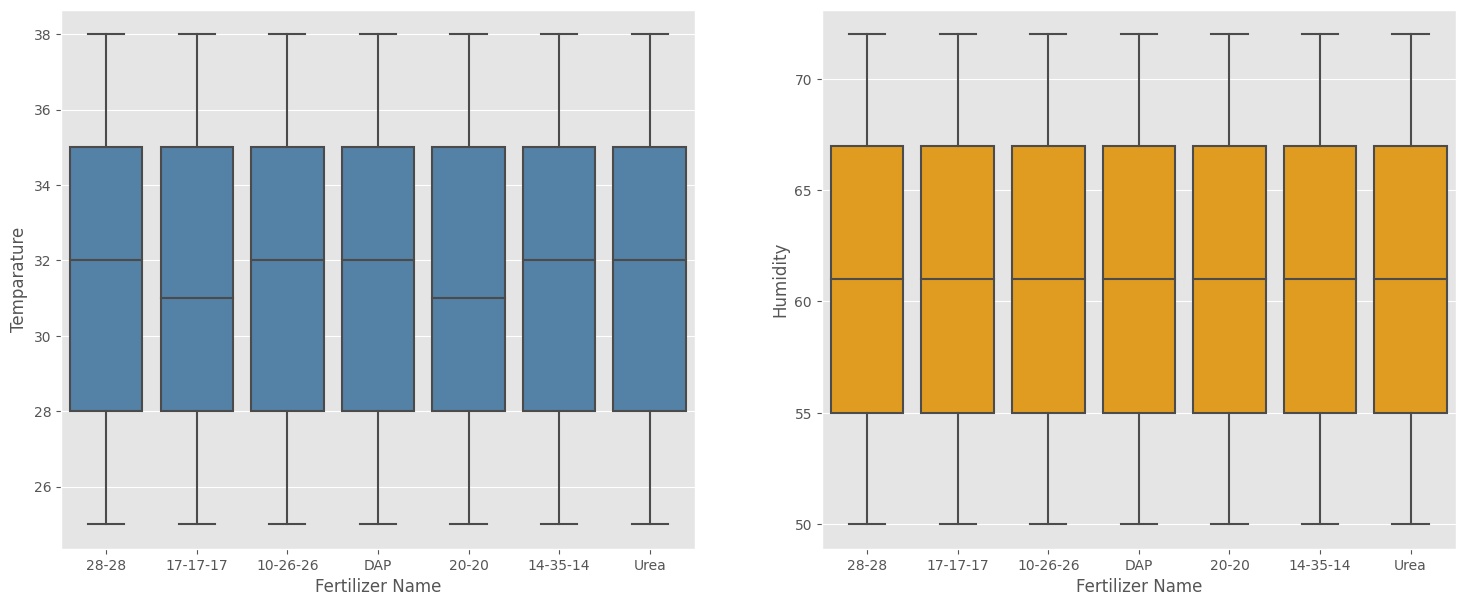

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

sns.boxplot(data=train, x="Fertilizer Name", y="Temparature", ax=ax[0], color="steelblue")
sns.boxplot(data=train, x="Fertilizer Name", y="Humidity", ax=ax[1], color="orange");

From the above charts, there is no an obvious relationship between `Temperature` or `Humidity` and `Fertilizer Name`.

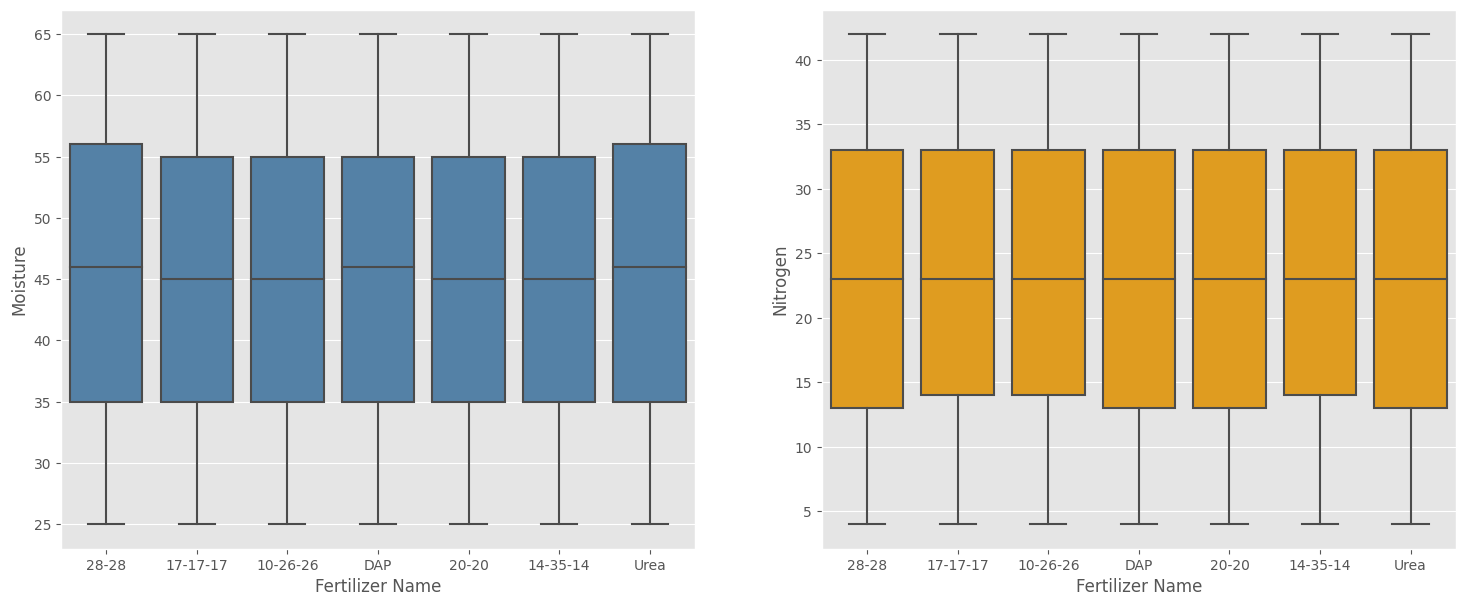

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

sns.boxplot(data=train, x="Fertilizer Name", y="Moisture", ax=ax[0], color="steelblue")
sns.boxplot(data=train, x="Fertilizer Name", y="Nitrogen", ax=ax[1], color="orange");

From the above charts, there is no an obvious relationship between `Moisture` or `Nitrogen` and `Fertilizer Name`.

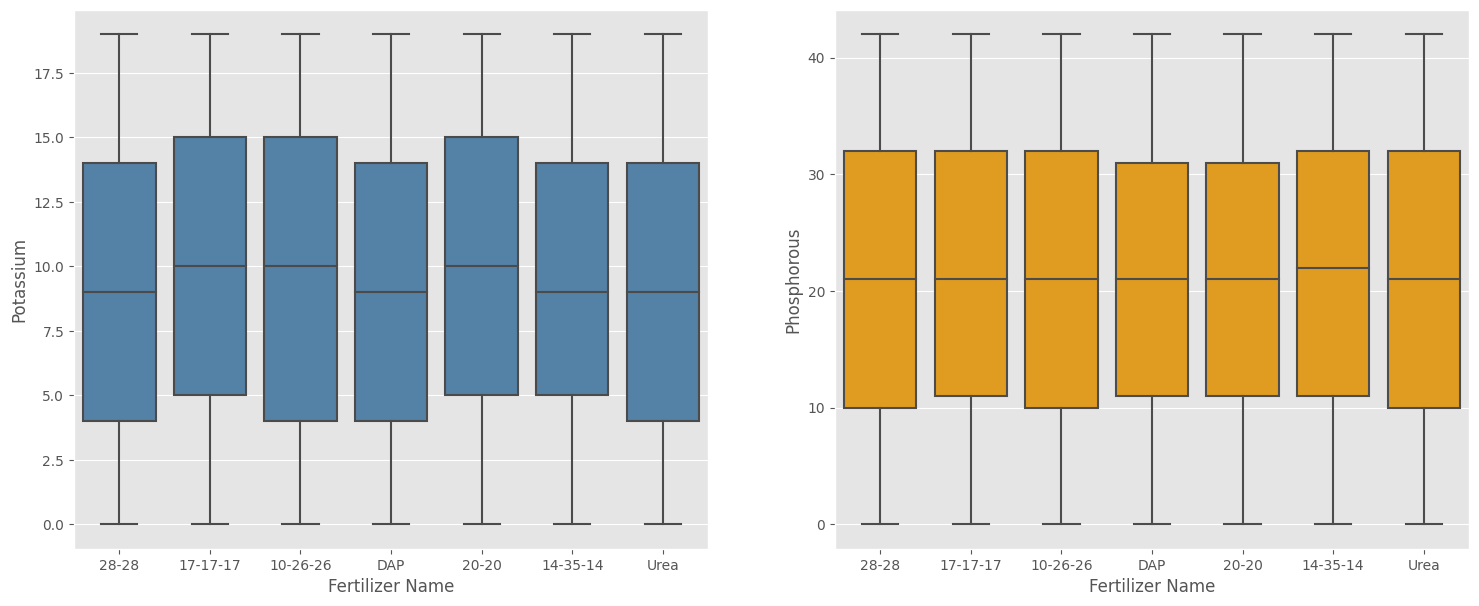

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

sns.boxplot(data=train, x="Fertilizer Name", y="Potassium", ax=ax[0], color="steelblue")
sns.boxplot(data=train, x="Fertilizer Name", y="Phosphorous", ax=ax[1], color="orange");

From the above charts, there is no an obvious relationship between `Potassium` or `Phosphorous` and `Fertilizer Name`.

# Baseline Modeling 1.0

In this section, we train a couple of standard models using the raw data. First, we define the input and target features as follows.

In [12]:
%%time
def apk(actual, predicted, k = 10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k = 10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


def selecting_top_3(arr): 
    n = arr.shape[0]
    out = np.zeros((n, 3))
    for i in range(0, n):
        out[i, ] = arr[i,].argsort()[::-1][:3]
    return out.astype('int32')

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.63 µs


In [13]:
%%time
X = train.drop(columns=["Fertilizer Name"], axis=1)
X["Soil Type"] = X["Soil Type"].astype("category")
X["Crop Type"] = X["Crop Type"].astype("category")
y = train["Fertilizer Name"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

test["Soil Type"] = test["Soil Type"].astype("category")
test["Crop Type"] = test["Crop Type"].astype("category")

del y
gc.collect()

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

CPU times: user 393 ms, sys: 13.4 ms, total: 406 ms
Wall time: 406 ms


Then, we train the `CatBoostClassifier` model over a 10-fold cross-validation strategy.

In [14]:
%%time
cat_params = {'loss_function': 'MultiClass',
 'iterations': 2000,
 'depth': 5,
 'bagging_temperature': 0.2,             
 'task_type': 'GPU'}

cat_features = ["Soil Type", "Crop Type"]
test_pool = Pool(data=test, cat_features=cat_features)

scores, test_preds = [], []
for i, (train_ix, test_ix) in enumerate(skf.split(X, y_encoded)):
        
    X_train, X_val = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_val = y_encoded[train_ix], y_encoded[test_ix]
                
    model_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)

    cat_md = CatBoostClassifier(**cat_params).fit(model_pool, eval_set=eval_pool, verbose=0, early_stopping_rounds=100)
    cat_pred = selecting_top_3(cat_md.predict_proba(X_val))
    
    score = mapk(y_val.reshape(-1, 1), cat_pred, k=3)
    print(f"Fold {i+1} MAP is {score:.4f}")
    scores.append(score)

    del model_pool, eval_pool
    gc.collect()

    test_preds.append(cat_md.predict_proba(test))
    
cat_cv_mean = np.mean(scores)
cat_cv_sd = np.std(scores)
print(f"The oof map3 score of the CatBoost model is {cat_cv_mean:.4f}")

Fold 1 MAP is 0.2728
Fold 2 MAP is 0.2749
Fold 3 MAP is 0.2758
Fold 4 MAP is 0.2766
Fold 5 MAP is 0.2744
Fold 6 MAP is 0.2755
Fold 7 MAP is 0.2738
Fold 8 MAP is 0.2744
Fold 9 MAP is 0.2743
Fold 10 MAP is 0.2737
The oof map3 score of the CatBoost model is 0.2746
CPU times: user 9min 21s, sys: 3min 3s, total: 12min 24s
Wall time: 6min 14s


In [15]:
%%time
pred_agg = 0
for i in range(0, len(test_preds)):
    pred_agg += test_preds[i] / len(test_preds)
    
test_pred = selecting_top_3(pred_agg)
test_pred = test_pred.astype('int32')

test_shape = test_pred.shape
top_3_predictions = le.inverse_transform(test_pred.reshape(-1, 1))
top_3_predictions = top_3_predictions.reshape(test_shape)

submission = pd.read_csv('../input/playground-series-s5e6/sample_submission.csv', index_col=0)
submission['Fertilizer Name'] = [' '.join(each) for each in top_3_predictions]
submission.head(10)

CPU times: user 825 ms, sys: 24.3 ms, total: 849 ms
Wall time: 904 ms


,Fertilizer Name
id,
750000,10-26-26 DAP 28-28
750001,17-17-17 20-20 10-26-26
750002,20-20 28-28 10-26-26
750003,14-35-14 DAP 17-17-17
750004,20-20 10-26-26 28-28
750005,28-28 14-35-14 20-20
750006,28-28 17-17-17 10-26-26
750007,28-28 DAP 17-17-17
750008,14-35-14 20-20 10-26-26


In [16]:
%%time
submission.to_csv('baseline_cat_sub_1.csv')

del submission, test_preds
gc.collect()

CPU times: user 411 ms, sys: 7.89 ms, total: 419 ms
Wall time: 419 ms


0

Then, we train the `XGBClassifier` model over a 10-fold cross-validation strategy.

In [17]:
%%time
xgb_params = {'device': 'cuda',
 'max_depth': 5,
 'learning_rate': 0.05,
 'min_child_weight': 50,
 'n_jobs': -1,
 'enable_categorical': True,
 'early_stopping_rounds': 200}

cat_features = ["Soil Type", "Crop Type"]

scores, test_preds = [], []
for i, (train_ix, test_ix) in enumerate(skf.split(X, y_encoded)):

    X_train, X_val = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_val = y_encoded[train_ix], y_encoded[test_ix]
    
    xgb_md = XGBClassifier(**xgb_params, 
                           n_estimators=2000, 
                           random_state=42).fit(X_train, y_train,
                           eval_set=[(X_val, y_val)],
                           # early_stopping_rounds=200,
                           verbose=False)
    xgb_pred = selecting_top_3(xgb_md.predict_proba(X_val))

    score = mapk(y_val.reshape(-1, 1), xgb_pred, k=3)
    print(f"Fold {i+1} MAP is {score:.4f}")
    scores.append(score)

    del X_train, X_val, y_train, y_val
    gc.collect()

    test_preds.append(xgb_md.predict_proba(test))

xgb_cv_mean = np.mean(scores)
xgb_cv_sd = np.std(scores)
print(f"The oof map3 score of the XGBoost model is {xgb_cv_mean:.4f}")

Fold 1 MAP is 0.2797
Fold 2 MAP is 0.2817
Fold 3 MAP is 0.2808
Fold 4 MAP is 0.2830
Fold 5 MAP is 0.2831
Fold 6 MAP is 0.2828
Fold 7 MAP is 0.2815
Fold 8 MAP is 0.2812
Fold 9 MAP is 0.2827
Fold 10 MAP is 0.2827
The oof map3 score of the XGBoost model is 0.2819
CPU times: user 17min 56s, sys: 32 s, total: 18min 28s
Wall time: 18min 13s


In [18]:
%%time
pred_agg = 0
for i in range(0, len(test_preds)):
    pred_agg += test_preds[i] / len(test_preds)
    
test_pred = selecting_top_3(pred_agg)
test_pred = test_pred.astype('int32')

test_shape = test_pred.shape
top_3_predictions = le.inverse_transform(test_pred.reshape(-1, 1))
top_3_predictions = top_3_predictions.reshape(test_shape)

submission = pd.read_csv('../input/playground-series-s5e6/sample_submission.csv', index_col=0)
submission['Fertilizer Name'] = [' '.join(each) for each in top_3_predictions]
submission.head(10)

CPU times: user 836 ms, sys: 12.6 ms, total: 849 ms
Wall time: 831 ms


,Fertilizer Name
id,
750000,28-28 10-26-26 DAP
750001,17-17-17 20-20 10-26-26
750002,20-20 28-28 10-26-26
750003,14-35-14 Urea DAP
750004,20-20 10-26-26 28-28
750005,28-28 20-20 14-35-14
750006,28-28 14-35-14 17-17-17
750007,DAP 28-28 17-17-17
750008,20-20 14-35-14 10-26-26


In [19]:
%%time
submission.to_csv('baseline_xgb_sub_1.csv')

del submission, test_preds
gc.collect()

CPU times: user 404 ms, sys: 9.91 ms, total: 414 ms
Wall time: 413 ms


0

Then, we train the `LGBMClassifier` model over a 10-fold cross-validation strategy.

In [20]:
%%time
lgb_params = {'learning_rate': 0.05,
 'n_estimators': 2000,
 'max_depth': 5,
 'num_leaves': 50,
 'verbose': -1,
 'n_jobs': -1,
 'device': 'gpu'}

cat_features = ["Soil Type", "Crop Type"]

scores, test_preds = [], []
for i, (train_ix, test_ix) in enumerate(skf.split(X, y_encoded)):

    X_train, X_val = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_val = y_encoded[train_ix], y_encoded[test_ix]
    
    lgb_md = LGBMClassifier(**lgb_params).fit(X_train, y_train, eval_set=[(X_val, y_val)],  
                                              callbacks=[early_stopping(stopping_rounds=200, verbose=None)])
    lgb_pred = selecting_top_3(lgb_md.predict_proba(X_val))

    score = mapk(y_val.reshape(-1, 1), lgb_pred, k=3)
    print(f"Fold {i+1} MAP is {score:.4f}")
    scores.append(score)

    del X_train, X_val, y_train, y_val
    gc.collect()

    test_preds.append(lgb_md.predict_proba(test))

lgb_cv_mean = np.mean(scores)
lgb_cv_sd = np.std(scores)
print(f"The oof map3 score of the LGBM model is {lgb_cv_mean:.4f}")

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Fold 1 MAP is 0.2805
Fold 2 MAP is 0.2835
Fold 3 MAP is 0.2846
Fold 4 MAP is 0.2843
Fold 5 MAP is 0.2861
Fold 6 MAP is 0.2864
Fold 7 MAP is 0.2839
Fold 8 MAP is 0.2838
Fold 9 MAP is 0.2839
Fold 10 MAP is 0.2840
The oof map3 score of the LGBM model is 0.2841
CPU times: user 4h 53min 49s, sys: 1min 50s, total: 4h 55min 39s
Wall time: 1h 15min 48s


In [21]:
%%time
pred_agg = 0
for i in range(0, len(test_preds)):
    pred_agg += test_preds[i] / len(test_preds)
    
test_pred = selecting_top_3(pred_agg)
test_pred = test_pred.astype('int32')

test_shape = test_pred.shape
top_3_predictions = le.inverse_transform(test_pred.reshape(-1, 1))
top_3_predictions = top_3_predictions.reshape(test_shape)

submission = pd.read_csv('../input/playground-series-s5e6/sample_submission.csv', index_col=0)
submission['Fertilizer Name'] = [' '.join(each) for each in top_3_predictions]
submission.head(10)

CPU times: user 852 ms, sys: 12 ms, total: 864 ms
Wall time: 843 ms


,Fertilizer Name
id,
750000,10-26-26 28-28 DAP
750001,17-17-17 20-20 10-26-26
750002,20-20 28-28 DAP
750003,14-35-14 DAP Urea
750004,20-20 10-26-26 28-28
750005,28-28 20-20 14-35-14
750006,28-28 14-35-14 20-20
750007,DAP 28-28 14-35-14
750008,20-20 14-35-14 10-26-26


In [22]:
%%time
submission.to_csv('baseline_lgb_sub_1.csv')

del submission, test_preds
gc.collect()

CPU times: user 412 ms, sys: 8.01 ms, total: 420 ms
Wall time: 419 ms


4

The below table summarizes the findings so far.

In [23]:
%%time
results_df = pd.DataFrame()
results_df["Model"] = ["CatBoost", "XGBoost", "LGBM"]
results_df["10-fold oof MAP@3"] = [round(cat_cv_mean, 4), round(xgb_cv_mean, 4), round(lgb_cv_mean, 4)]
results_df

CPU times: user 1.91 ms, sys: 0 ns, total: 1.91 ms
Wall time: 1.92 ms


,Model,10-fold oof MAP@3
0,CatBoost,0.2746
1,XGBoost,0.2819
2,LGBM,0.2841
